In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#Get all column names for both classes
print(Measurement.__table__.columns.keys())
print(Station.__table__.columns.keys())

['id', 'station', 'date', 'prcp', 'tobs']
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


[]

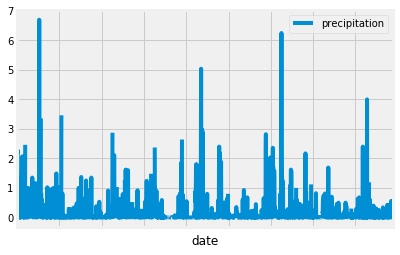

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Make sure to get only the string portion by using [0], the change to date format
lastDate = (session.query(Measurement.date)
                .order_by(Measurement.date.desc())
                .first())[0]
lastDate = dt.datetime.strptime(lastDate, '%Y-%m-%d')


# Calculate the date 1 year ago from the last data point in the database
oneYearBefore = lastDate - dt.timedelta(days =365) 

# Perform a query to retrieve precipitation data
preciData = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > oneYearBefore)
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
preciData_df = pd.DataFrame(preciData).set_index('date')
preciData_df = preciData_df.rename(columns = {"prcp":"precipitation"})
preciData_df 

# Sort the dataframe by date
preciData_df = preciData_df.sort_index(ascending = True)
preciData_df

# Use Pandas Plotting with Matplotlib to plot the data
preciData_df.plot().set_xticklabels([])


In [12]:
preciData_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stationCount = session.query(Station).count()
print("Station count: " + str(stationCount))

Station count: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationCount = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stationCount

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Get name of most activie staion
mostActive = stationCount[0][0]

# Query lowest temp of station
lowestTemp = (session.query(Measurement.tobs)
              .filter_by(station = mostActive)
              .order_by(Measurement.tobs.asc()).first())[0]

# Query highest temp of station
highestTemp = (session.query(Measurement.tobs)
              .filter_by(station = mostActive)
              .order_by(Measurement.tobs.desc()).first())[0]

# Query for average them 
avgTemp = session.query(func.avg(Measurement.tobs)).filter_by(station = mostActive)[0][0]

print("Most Active Station: " + mostActive)
print("Lowest Temperature: " + str(lowestTemp))
print("Highest Temperature: " + str(highestTemp))
print("Average Temperature: " + str(avgTemp))


Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


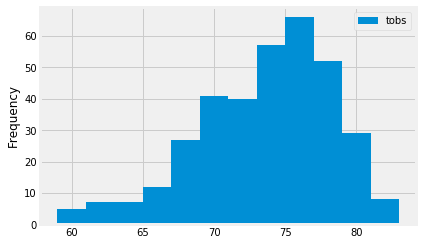

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Perform a query to retrieve temp info
tempData = (session.query(Measurement.date, Measurement.tobs)
                  .filter(Measurement.date > oneYearBefore)
                  .filter(Measurement.station == mostActive)
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
tempData_df = pd.DataFrame(tempData).set_index('date')
tempData_df 

# Sort the dataframe by date
tempData_df = tempData_df.sort_index(ascending = True)
tempData_df

# Plot histogram
tempData_df.plot(kind='hist', bins=12)

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tripStart = '2017-04-08'
tripEnd = '2017-04-19'

tripTemps = calc_temps(tripStart, tripEnd)

print()




[(67.0, 73.6, 83.0)]


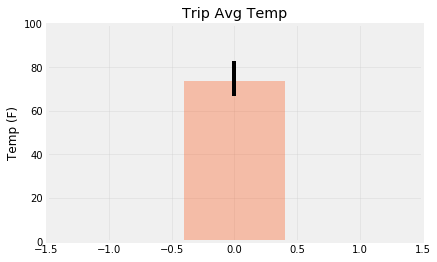

In [72]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
minTripTemp = tripTemps[0][0]
avgTripTemp = tripTemps[0][1]
maxTripTemp = tripTemps[0][2]

minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp

errorBars = np.array([[minError], [maxError]])

plt.bar(0, avgTripTemp, yerr=errorBars, color = 'orangered', alpha = 0.3)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=0.3)



In [118]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(Station.name, func.sum(Measurement.prcp),Station.latitude, Station.longitude, Station.elevation)\
            .filter(Station.station == Measurement.station)\
            .filter(Measurement.date>=tripStart)\
            .filter(Measurement.date<=tripEnd)\
            .group_by(Station.station)\
            .order_by(func.sum(Measurement.prcp).desc()).all()  


# Turn results into df and rename for easier view
results_df = pd.DataFrame(np.array(results))
results_df = results_df.rename(columns={0:'Station', 1: 'Total Precipitation', 2: 'Latitude', 3: 'Longitude', 4: "Elevation"})
results_df

,Station,Total Precipitation,Latitude,Longitude,Elevation
0,"MANOA LYON ARBO 785.2, HI US",7.38,21.3331,-157.8025,152.4
1,"WAIHEE 837.5, HI US",6.979999999999999,21.45167,-157.84888999999998,32.9
2,"KANEOHE 838.1, HI US",2.48,21.4234,-157.8015,14.6
3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.86,21.5213,-157.8374,7.0
4,"WAIMANALO EXPERIMENTAL FARM, HI US",0.8099999999999999,21.33556,-157.71139,19.5
5,"WAIKIKI 717.2, HI US",0.31000000000000005,21.2716,-157.8168,3.0
6,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9
